In [1]:
import os 
#data_location = input("Enter Path Location of data")
os.chdir("/home/mitchell/Documents/masters/masters/scripts/")
import galaxy_pairs
os.chdir("/home/mitchell/Documents/masters/masters/data")
cwd = os.getcwd()
print(cwd)

/home/mitchell/Documents/masters/masters/data


In [2]:
import numpy as np
import scipy as sp
import astropy as ap
import glob
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy.constants as const
from astropy import constants as ap_const
import scipy.ndimage 
import PIL
import sptpol_software as sps
from astropy.io import fits
from astropy.cosmology import Planck15
from astropy import units as u
import scipy.spatial.distance as dist
print(Planck15)
cosmo= Planck15

FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)


In [3]:
from sptpol_software.util.tools import stat
from sptpol_software.observation import *
import sptpol_software.observation as obs
import sptpol_software as sps
import sptpol_software.observation.sky
from sptpol_software.util import files

pywtl packages could not be imported.  This may break plotting code.


In [4]:
T_cmb = 2.725
freqs_ghz = [93.2000,147.700]
beam_norm_correction = [1./0.99673, 1./0.99470, 1./1. ] 
pol_cal_factors_800 = [0.9097,0.7765,0] # no 220 is why last is zero. 
#pol_cal_factors = pol_cal_factors_800 * beam_norm_correction

In [5]:
glob.glob('*.h5')

['ra0hdec-57.5_ra0hdec-57p5_20140706_073929_090ghz.h5',
 'ra0dec-57p5_sum1000_090ghz.h5',
 'ra0dec-57p5_sum5000_150ghz.h5',
 'y_map.h5',
 'ra0hdec-57.5_ra0hdec-57p5_20140706_073929_150ghz.h5',
 'ra0dec-57p5_sum100Weighted_150ghz.h5',
 'ra0dec-57p5_sum1000_150ghz.h5',
 'ra0dec-57p5_sum_150ghz.h5',
 'ra0dec-57p5_sum100Weighted_090ghz.h5',
 'first_coadd_test_fbcode.h5',
 'test.h5',
 'ra0dec-57p5_sum5000_090ghz.h5',
 'ra0dec-57p5_sum_090ghz.h5']

In [6]:
map_150ghz = files.read("ra0dec-57p5_sum5000_150ghz.h5")
map_90ghz = files.read("ra0dec-57p5_sum5000_090ghz.h5")

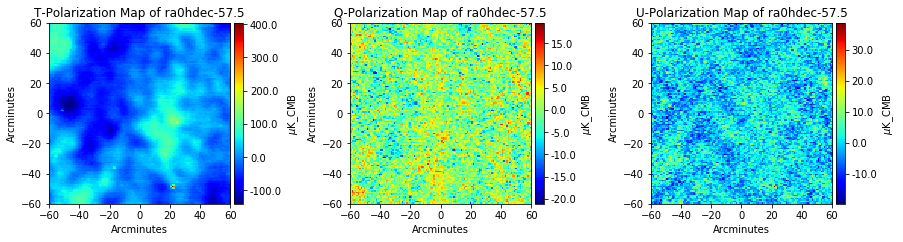

<Figure size 432x288 with 0 Axes>

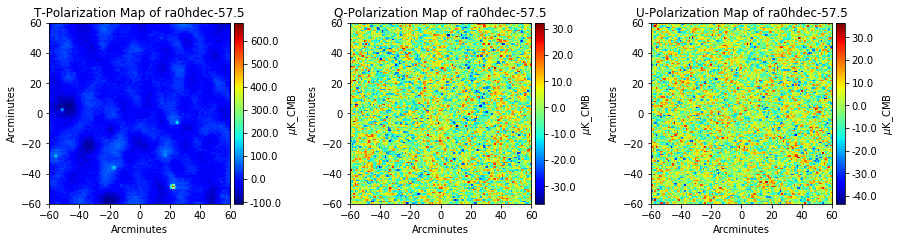

<Figure size 432x288 with 0 Axes>

In [47]:
map_150ghz.getSubmap([2,2], center_offset=[0,0], units='degree').drawImage(bw=False)
map_90ghz.getSubmap([2,2], center_offset=[0,0], units='degree').drawImage(bw=False)

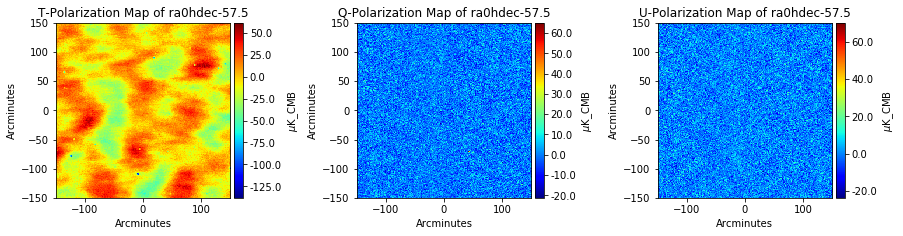

<Figure size 432x288 with 0 Axes>

In [8]:
diff_T = map_150ghz-map_90ghz
diff_T.getSubmap([5,5], center_offset=[1,1], units='degree').drawImage(bw=False)

In [9]:
def convert_ghz_to_y(freq_power):
    x = freq_power/56.85  # x = h v / k_B T_CMB
    return((x/np.tanh(x/2)) - 4)
print(convert_ghz_to_y(90))
print(convert_ghz_to_y(150))

-1.598760150351676
-0.9553171397183053


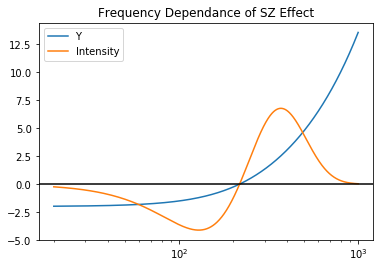

In [10]:
freq_range = np.arange(20,1000,1)
x = freq_range/56.85
y_param = [(ex/np.tanh(ex/2) - 4) for ex in x]
plt.semilogx(freq_range,y_param,label='Y')
I_v = [(ex**4 * np.exp(ex))/(np.exp(ex)-1)**2 * (ex/np.tanh(ex/2) - 4) for ex in x]
plt.semilogx(freq_range,I_v,label='Intensity')
plt.axhline(0, color='black')
plt.title('Frequency Dependance of SZ Effect')
plt.legend()

In [11]:
map_150ghz_array = map_150ghz.getTOnly().map
print(type(map_150ghz))

<class 'sptpol_software.observation.sky.PolarizedObservedSky'>


In [12]:
freq_scaling = convert_ghz_to_y(150)-convert_ghz_to_y(90)
print(freq_scaling)
freq_scaling_fac = 1.0/freq_scaling
print(freq_scaling_fac)

0.6434430106333706
1.5541391909994544


In [13]:
#y_map = sptpol_software.observation.sky.Map
y_map = freq_scaling_fac*(map_150ghz-map_90ghz)
#/(convert_ghz_to_y(150)-convert_ghz_to_y(90))

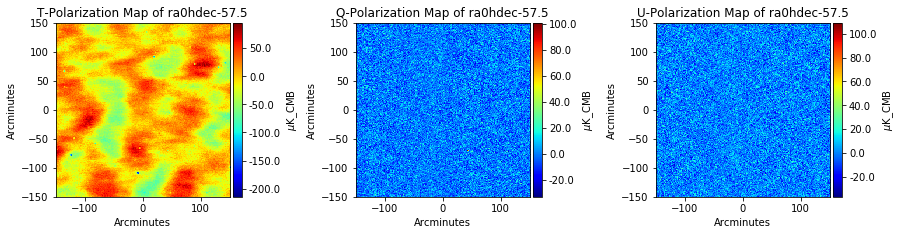

Functionally a factor of 2 conversion, look at scale


<Figure size 432x288 with 0 Axes>

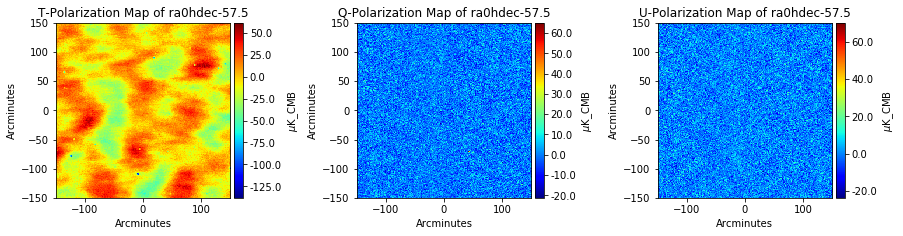

<Figure size 432x288 with 0 Axes>

In [14]:
y_map.getSubmap([5,5], center_offset=[1,1], units='degree').drawImage(bw=False)
print("Functionally a factor of 2 conversion, look at scale")
diff_T.getSubmap([5,5], center_offset=[1,1], units='degree').drawImage(bw=False)


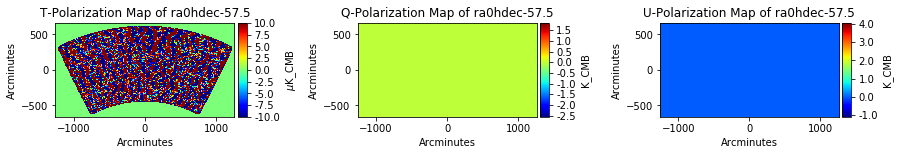

<Figure size 432x288 with 0 Axes>

In [15]:
y_map.drawImage(bw=False,vmax=-0.00001,vmin=0.00001)

In [16]:
# y_map.writeToHDF5('y_map.h5',overwrite=True,use_compression=False)

In [17]:
# red_mapper_cat = fits.open("DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits")
from astropy.table import Table
dat = Table.read('DES_Y1A1_3x2pt_redMaGiC_zerr_CATALOG.fits', format='fits')
df = dat.to_pandas()

In [18]:
# red_mapper_cat.info()
# df['ZREDMAGIC']

In [19]:
# com_dists = cosmo.comoving_distance(df['ZREDMAGIC']).to_value(u.Mpc)
df['COMOVING'] = pd.Series(cosmo.comoving_distance(df['ZREDMAGIC']).to_value(u.Mpc))
df['COMOVING_E'] = pd.Series(cosmo.comoving_distance(df['ZREDMAGIC_E']).to_value(u.Mpc))

In [20]:
help(galaxy_pairs.getPairs)

Help on function getPairs in module galaxy_pairs:

getPairs(data_frame, max_sep=20, results_loc='PAIRS_sparse_dist.npz', save_frame=False)
    Takes a data frame with RA, DEC, and COMOVING distances, and pairs
    up those vectors with the closest vector under a given maximum separation
    and store the results in an array where:
    results[0] = First Item
    results[1] = Second Item
    results[2] = Distance between First Item and Second Item



In [21]:
# print(df)
pairs = galaxy_pairs.getPairs(df,20)
# First index is first item in pair
# Second index in second item in pair
# Third Index is distance apart from each other

In [22]:
print(pairs)

[[6.45602000e+05 6.51449000e+05 6.45787000e+05 ... 5.53580000e+05
  5.55787000e+05 5.55787000e+05]
 [6.45787000e+05 6.52553000e+05 6.47190000e+05 ... 5.56079000e+05
  5.56079000e+05 5.59605000e+05]
 [1.94407051e+01 1.26949222e+01 1.72683966e+01 ... 1.45103301e+01
  1.61456102e+01 1.26293600e+01]]


In [34]:
def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(length):
        distance += pow((instance1[x] - instance2[x]), 2)
    return np.sqrt(distance)
    

In [ ]:
vec1 = get_vec_distances(df['RA'][0],df['DEC'][0],df['COMOVING'][0])
vec2 = get_vec_distances(df['RA'][1],df['DEC'][1],df['COMOVING'][1])
print(euclideanDistance(vec1,vec2,3))

In [ ]:
df.to_csv('DES_REDMAGIC_Manipulated.csv')

In [ ]:
vec_unit_test = RaDec2XYZ(df['RA'],df['DEC'])
print(vec_unit_test)
print(np.shape(vec_unit_test))
vec_unit_test2 = vec_unit_test[0]
print(vec_unit_test2)